In [49]:
# Core libraries
import pandas as pd
import numpy as np
import sqlite3
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning (we’ll use later)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Change to project root (adjust as needed)
os.chdir("C:/Projects/Emissions_Analysis_Capstone")

CO₂ Emissions Comparison (Total + Per Vehicle):


,Category,Total_CO2_kg_per_year,Total_CO2_million_tonnes_per_year,Per_Unit_CO2_kg_per_year
0,Cattle Meat (NA),5.782722e+10,57827.215356,NaN
1,"Vehicles (NA, 2015 sales)",1.006528e+10,10065.278941,576.13002


C:\Users\derek\AppData\Local\Temp\ipykernel_21972\3501279111.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


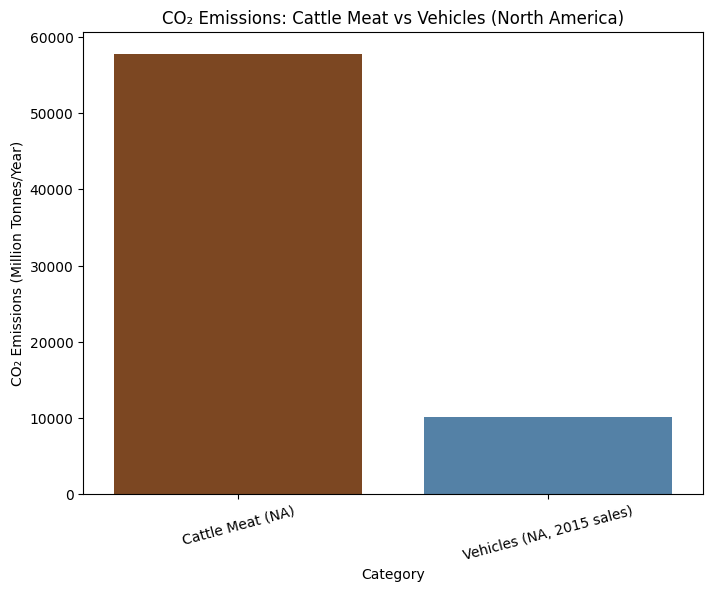

C:\Users\derek\AppData\Local\Temp\ipykernel_21972\3501279111.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


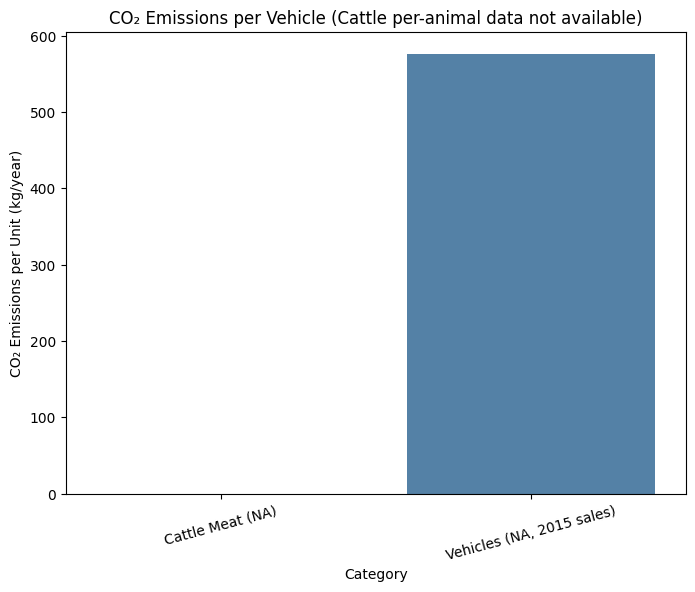

In [104]:
db_path = os.path.join('emissions_data', 'emissionsdata.sqlite')
os.makedirs(os.path.dirname(db_path), exist_ok=True)
conn = sqlite3.connect(db_path)

# === Livestock query (without population column) ===
livestock_query = """
SELECT
    region,
    animal_type,
    commodity,
    co2_emissions_kg,
    n2o_emissions_kg
FROM livestock_emissions;
"""
livestock_df = pd.read_sql(livestock_query, conn)

# Filter livestock to North America, cattle, meat commodity
cattle_meat_na_df = livestock_df[
    (livestock_df["region"] == "North America") &
    (livestock_df["animal_type"] == "Cattle") &
    (livestock_df["commodity"] == "Meat")
].copy()

# Calculate total cattle CO2 emissions
cattle_total_CO2_kg = cattle_meat_na_df["co2_emissions_kg"].sum()
cattle_total_CO2_million_tonnes = cattle_total_CO2_kg / 1e6

# === Vehicle query ===
vehicle_query = """
SELECT
    make,
    model,
    co2_emissions_g_per_km,
    fuel_type
FROM vehicle_emissions;
"""
vehicle_df = pd.read_sql(vehicle_query, conn)

# Convert CO2 column to numeric
vehicle_df["co2_emissions_g_per_km"] = pd.to_numeric(
    vehicle_df["co2_emissions_g_per_km"], errors="coerce"
)

# Convert g/km → kg/km
vehicle_df["co2_emissions_kg_per_km"] = vehicle_df["co2_emissions_g_per_km"] / 1000

# Multiply by average annual mileage to get kg/year
AVG_KM_PER_YEAR = 16094  # 10,000 miles
vehicle_df["co2_emissions_kg_per_year"] = vehicle_df["co2_emissions_kg_per_km"] * AVG_KM_PER_YEAR

# Dataset aggregates 7 years, divide by NUM_YEARS to get avg per year
NUM_YEARS = 7
vehicle_df["co2_emissions_kg_per_year"] = vehicle_df["co2_emissions_kg_per_year"] / NUM_YEARS

# Total vehicles sold in 2015 (NA)
TOTAL_VEHICLES_2015 = 17_470_499
vehicle_total_CO2_kg_2015 = vehicle_df["co2_emissions_kg_per_year"].mean() * TOTAL_VEHICLES_2015
vehicle_total_CO2_million_tonnes = vehicle_total_CO2_kg_2015 / 1e6

# CO2 per vehicle per year
vehicle_CO2_per_vehicle_kg_per_year = vehicle_df["co2_emissions_kg_per_year"].mean()

# === Summary comparison (totals + per-vehicle) ===
summary_df = pd.DataFrame({
    "Category": ["Cattle Meat (NA)", "Vehicles (NA, 2015 sales)"],
    "Total_CO2_kg_per_year": [cattle_total_CO2_kg, vehicle_total_CO2_kg_2015],
    "Total_CO2_million_tonnes_per_year": [cattle_total_CO2_million_tonnes, vehicle_total_CO2_million_tonnes],
    "Per_Unit_CO2_kg_per_year": [None, vehicle_CO2_per_vehicle_kg_per_year]
})

print("CO₂ Emissions Comparison (Total + Per Vehicle):")
display(summary_df)

# === Visualization: Total emissions ===
plt.figure(figsize=(8,6))
sns.barplot(
    x="Category",
    y="Total_CO2_million_tonnes_per_year",
    data=summary_df,
    palette=["saddlebrown", "steelblue"]
)
plt.ylabel("CO₂ Emissions (Million Tonnes/Year)")
plt.title("CO₂ Emissions: Cattle Meat vs Vehicles (North America)")
plt.xticks(rotation=15)
plt.show()

# === Visualization: Per-vehicle emissions ===
plt.figure(figsize=(8,6))
sns.barplot(
    x="Category",
    y="Per_Unit_CO2_kg_per_year",
    data=summary_df,
    palette=["saddlebrown", "steelblue"]
)
plt.ylabel("CO₂ Emissions per Unit (kg/year)")
plt.title("CO₂ Emissions per Vehicle (Cattle per-animal data not available)")
plt.xticks(rotation=15)
plt.show()

In [105]:
print(vehicle_df.columns.tolist())

AVG_KM_PER_YEAR = 15000

# Double-check column name exists exactly
if "co2_emissions_g_per_km" in vehicle_df.columns:
    vehicle_df["co2_emissions_kg_per_km"] = vehicle_df["co2_emissions_g_per_km"] / 1000
    vehicle_df["co2_emissions_kg_per_year"] = vehicle_df["co2_emissions_kg_per_km"] * AVG_KM_PER_YEAR
else:
    print("⚠️ Column not found. Check column names above.")

['make', 'model', 'co2_emissions_g_per_km', 'fuel_type', 'co2_emissions_kg_per_km', 'co2_emissions_kg_per_year']


In [106]:
# --- Livestock CO2 statistics ---
print("=== Livestock CO2 Emissions (kg/year) ===")
livestock_stats = livestock_df["co2_emissions_kg"].describe()
display(livestock_stats)

# --- Vehicle CO2 statistics ---
print("\n=== Vehicle CO2 Emissions (kg/year) ===")
vehicle_stats = vehicle_df["co2_emissions_kg_per_year"].describe()
display(vehicle_stats)

=== Livestock CO2 Emissions (kg/year) ===


count    5.830000e+02
mean     2.547730e+10
std      8.311139e+10
min      0.000000e+00
25%      1.509816e+08
50%      1.882964e+09
75%      1.089344e+10
max      9.449299e+11
Name: co2_emissions_kg, dtype: float64


=== Vehicle CO2 Emissions (kg/year) ===


count    7385.000000
mean     3758.770481
std       877.690191
min      1440.000000
25%      3120.000000
50%      3690.000000
75%      4320.000000
max      7830.000000
Name: co2_emissions_kg_per_year, dtype: float64

In [107]:
comparison_summary = pd.DataFrame({
    "Category": ["Livestock", "Vehicles"],
    "Total_CO2_kg_per_year": [
        livestock_df["co2_emissions_kg"].sum(),
        vehicle_df["co2_emissions_kg_per_year"].sum()
    ],
    "Mean_CO2_kg_per_year": [
        livestock_df["co2_emissions_kg"].mean(),
        vehicle_df["co2_emissions_kg_per_year"].mean()
    ],
    "Median_CO2_kg_per_year": [
        livestock_df["co2_emissions_kg"].median(),
        vehicle_df["co2_emissions_kg_per_year"].median()
    ],
    "Std_CO2_kg_per_year": [
        livestock_df["co2_emissions_kg"].std(),
        vehicle_df["co2_emissions_kg_per_year"].std()
    ]
})

display(comparison_summary)

,Category,Total_CO2_kg_per_year,Mean_CO2_kg_per_year,Median_CO2_kg_per_year,Std_CO2_kg_per_year
0,Livestock,1.485327e+13,2.547730e+10,1.882964e+09,8.311139e+10
1,Vehicles,2.775852e+07,3.758770e+03,3.690000e+03,8.776902e+02


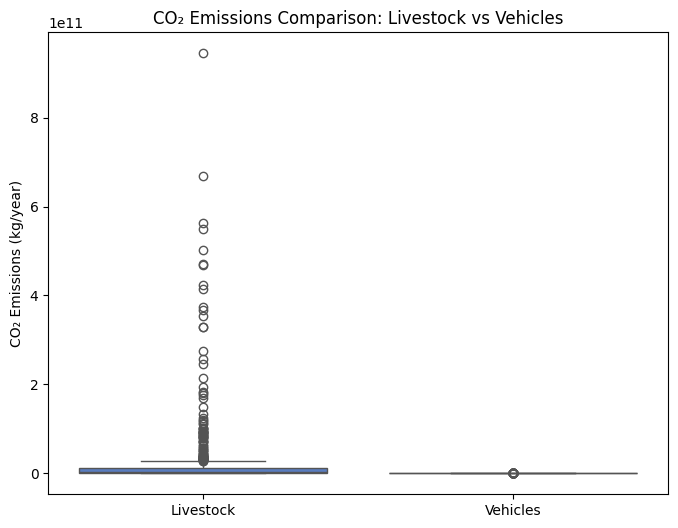

In [108]:

plt.figure(figsize=(8,6))
sns.boxplot(data=[
    livestock_df["co2_emissions_kg"],
    vehicle_df["co2_emissions_kg_per_year"]
], palette="muted")
plt.xticks([0,1], ["Livestock", "Vehicles"])
plt.ylabel("CO₂ Emissions (kg/year)")
plt.title("CO₂ Emissions Comparison: Livestock vs Vehicles")
plt.show()

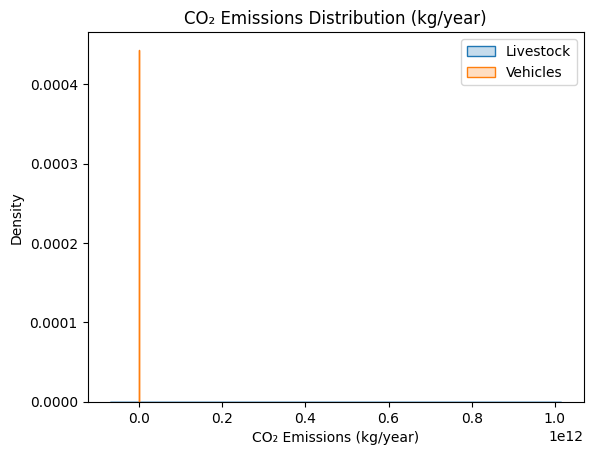

In [109]:
sns.kdeplot(livestock_df["co2_emissions_kg"], label="Livestock", fill=True)
sns.kdeplot(vehicle_df["co2_emissions_kg_per_year"], label="Vehicles", fill=True)
plt.title("CO₂ Emissions Distribution (kg/year)")
plt.xlabel("CO₂ Emissions (kg/year)")
plt.legend()
plt.show()

In [110]:
comparison_summary = pd.DataFrame({
    "Category": ["Livestock", "Vehicles"],
    "Mean_CO2_kg_per_year": [
        livestock_df["co2_emissions_kg"].mean(),
        vehicle_df["co2_emissions_kg_per_year"].mean()
    ]
})
display(comparison_summary)

,Category,Mean_CO2_kg_per_year
0,Livestock,2.547730e+10
1,Vehicles,3.758770e+03


In [111]:
plt.figure(figsize=(10,6))
sns.kdeplot(vehicle_df['co2_emissions_kg'], fill=True, label='Vehicles')
sns.kdeplot(livestock_df['co2_emissions_kg'], fill=True, label='Livestock')
plt.title('CO₂ Emissions Comparison (kg)')
plt.xlabel('CO₂ Emissions (kg)')
plt.ylabel('Density')
plt.legend()
plt.show()

KeyError: 'co2_emissions_kg'

<Figure size 1000x600 with 0 Axes>

C:\Users\derek\AppData\Local\Temp\ipykernel_21972\2033774492.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Source', y='CO2 Emissions (kg)', data=combined, palette='Set2')


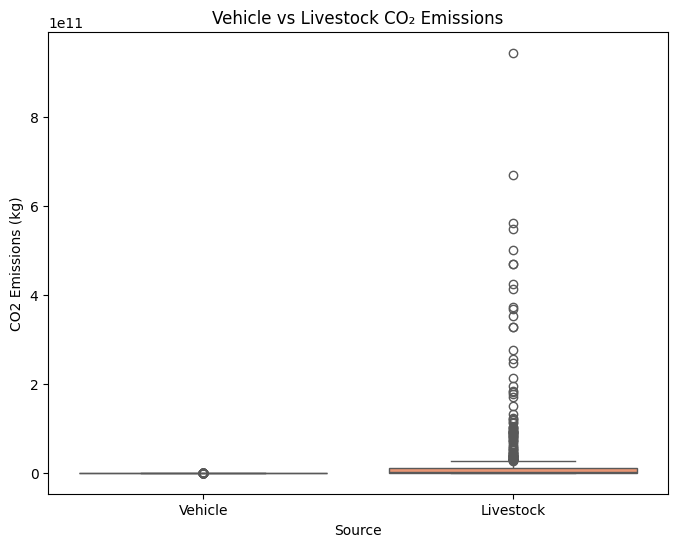

In [ ]:
combined = pd.DataFrame({
    'CO2 Emissions (kg)': pd.concat([vehicle_df['co2_emissions_kg'], livestock_df['co2_emissions_kg']]),
    'Source': ['Vehicle']*len(vehicle_df) + ['Livestock']*len(livestock_df)
})

plt.figure(figsize=(8,6))
sns.boxplot(x='Source', y='CO2 Emissions (kg)', data=combined, palette='Set2')
plt.title('Vehicle vs Livestock CO₂ Emissions')
plt.show()

In [ ]:
plt.figure(figsize=(10,6))

sns.kdeplot(vehicle_subset['co2_emissions_kg'], label='Vehicles', fill=True)
sns.kdeplot(livestock_df['co2_emissions_kg'], label='Livestock', fill=True)

plt.title('CO₂ Emissions Comparison (kg)')
plt.xlabel('CO₂ Emissions (kg)')
plt.ylabel('Density')
plt.legend()
plt.show()

NameError: name 'vehicle_subset' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:
print(livestock_df.columns.tolist())